In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

Sample Data:                                          Instruction  \
0  What is the difference between a petition and ...   
1     When should a writ petition be filed in India?   
2  What is the procedure for filing a plaint in a...   
3  What are the common reliefs sought through a p...   
4  Can a plaint be amended after it has been file...   

                                            Response  
0  A petition is a formal request submitted to a ...  
1  A writ petition in India should be filed when ...  
2  To file a plaint in a civil case in Indiayou m...  
3  Public interest litigation (PIL) petitions in ...  
4  Yesa plaint can be amended in a civil case in ...  


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,4.661500,4.741390,0.000000,0.000000
2,4.503900,4.790797,0.000000,0.000000
3,4.422200,4.806220,0.000000,0.000000



Evaluation Results: {'eval_loss': 4.806220054626465, 'eval_accuracy': 0.0, 'eval_precision': 0.0, 'eval_runtime': 3.6446, 'eval_samples_per_second': 5.488, 'eval_steps_per_second': 0.823, 'epoch': 3.0}


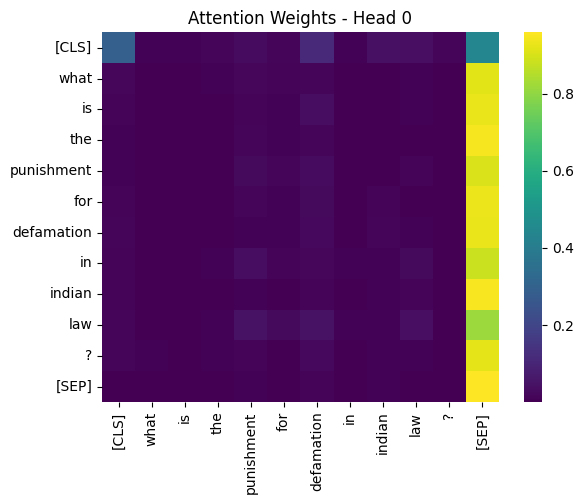

In [ ]:
# Indian Law Dataset Classification with Transformer (Hugging Face Dataset)
# ---------------------------------------------------------------------

from datasets import load_dataset
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score

# 1. Load the Indian Law Dataset from Hugging Face
ds = load_dataset("viber1/indian-law-dataset")

# Convert Hugging Face dataset to Pandas DataFrame
data = pd.DataFrame(ds['train'])

# Display sample data
print("Sample Data:", data.head())

# Rename for consistency
# The columns are 'Instruction' and 'Response'
data = data.rename(columns={"Instruction": "text", "Response": "label_text"})

# Subset the data for a smaller training run
data = data.sample(n=100, random_state=42).reset_index(drop=True)

# 2. Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['label_text'])

# 3. Preprocess the Dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["text"], data["label"], test_size=0.2, random_state=42
)

# 4. Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=512
)
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=512
)

train_labels = torch.tensor(train_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())

# 5. Dataset Class
class IndianLawDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IndianLawDataset(train_encodings, train_labels)
val_dataset = IndianLawDataset(val_encodings, val_labels)

# 6. Load Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(le.classes_))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    return {"accuracy": acc, "precision": prec}

# 7. Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

# 8. Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 9. Train the Model
trainer.train()

# 10. Evaluate the Model
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)

# 11. Save the Model
model.save_pretrained("./indian_law_model")
tokenizer.save_pretrained("./indian_law_model")

# 12. Attention Visualization Function (Optional)
def visualize_attention(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions[-1][0]  # Last layer attention
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Show heatmap for head 0
    attn = attentions[0].detach().numpy()
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title("Attention Weights - Head 0")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Example (Optional):
visualize_attention(model, tokenizer, "What is the punishment for defamation in Indian law?")


In [ ]:
# Save model and tokenizer
model.save_pretrained("indian_law_model")
tokenizer.save_pretrained("indian_law_model")

# Save label classes for decoding predictions
import numpy as np
np.save("indian_law_model/label_classes.npy", le.classes_)

from google.colab import files
import shutil
shutil.make_archive("indian_law_model", 'zip', "indian_law_model")
files.download("indian_law_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 13. Predict Function
def predict(text):
    model.eval()  # Set model to evaluation mode
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
        return le.inverse_transform([predicted_class_id])[0]

# 14. Example Predictions
test_queries = [
    "what does article 370 states?"
]

print("\n--- Model Predictions on Test Inputs ---")
for query in test_queries:
    result = predict(query)
    print(f"Input: {query}\nPredicted Response: {result}\n")



--- Model Predictions on Test Inputs ---
Input: what does article 370 states?
Predicted Response: The Parliament has exclusive legislative powers over the All-India Services, as mentioned in the Union List of the Seventh Schedule. The Parliament is responsible for the constitution, organization, and regulation of these services, which include the Indian Administrative Service, Indian Police Service, and Indian Forest Service. The All-India Services serve both the Union and State governments, ensuring uniformity and efficiency in administration across the country.

